# Example of adversarial attacks

We will see here that although CNN allowed huge progress for tasks such as classification, they can be cheated by a small, undetectable amount of noise.
This noise is called adversarial noise and the aim of this notebook is to create this kind of noise.

In [1]:
import importlib.util
import sys
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#pwd
%ls
%cd "/content/gdrive/My Drive/dlia_course/practical_sessions_share"

Mounted at /content/gdrive
gdrive/  sample_data/
/content/gdrive/My Drive/dlia_course/practical_sessions_share


In [2]:
import os
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras import losses
import keras.backend as K

Using TensorFlow backend.


We load a pretrained convolutional neural network: [VGG19](https://keras.io/applications/#vgg19).

In [3]:
from keras.applications import vgg19
from keras.applications.vgg19 import preprocess_input
model = vgg19.VGG19(weights='imagenet', include_top=True)
model.summary()











Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)   

As the model is pretrained on [ImageNet](http://www.image-net.org/), can use any picture from everyday life as an example. Here, we will use a picture of a dog.

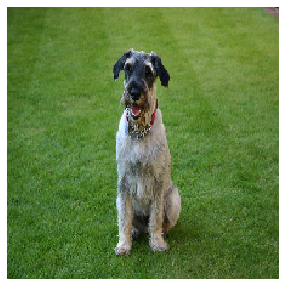

In [4]:

#path_dog = "./imagenet/425248370_b15374000e.jpg"
path_dog='425248370_b15374000e.jpg'
image_dog = load_img(path_dog, target_size=(224, 224))
plt.figure(figsize=(5, 5))
plt.imshow(image_dog)
plt.axis('off')
plt.show()

In [5]:
pwd


'/content/gdrive/My Drive/dlia_course/practical_sessions_share'

We make a prediction with VGG19.

In [6]:
x = img_to_array(image_dog)
x = np.expand_dims(x, axis=0) #add the batch dimension
x = x.astype('float32')
x = preprocess_input(x)
print(x.shape, x.dtype)

(1, 224, 224, 3) float32


In [7]:
predictions = model.predict(np.array(x))
decoded_prediction = vgg19.decode_predictions(predictions)
print(predictions.shape, predictions.dtype, "\n")

# return the 5 most probable classes
for i in decoded_prediction[0]:
    print(i[1], i[2])

40960/35363 [==================================] - 0s 0us/step
(1, 1000) float32 

Irish_wolfhound 0.379421
standard_schnauzer 0.20018274
wire-haired_fox_terrier 0.099777006
Scottish_deerhound 0.08937387
giant_schnauzer 0.06695007


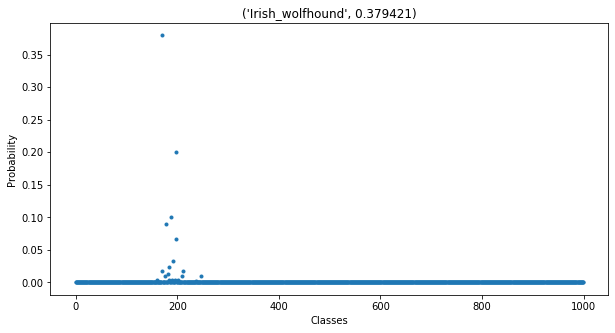

In [8]:
# plot the probability for each of the 1000 classes available
nb_classes = predictions.shape[1]
plt.figure(figsize=(10, 5))
plt.plot(predictions[0,:], '.')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title(decoded_prediction[0][0][1:])
plt.show()

Now, we will add an imperceptible noise in the image to fail our classifier. In order to do that, the keras.backend K (and more specifically the K.function) will help us to manipulate different low-level element of the library and "chain" the elements needed to compute an adversarial noise.


In [9]:
# We start from an input image (preprocessed)
# lets define the input for the noise generation.
# These variables will then be instanciated.
input_image = model.input
input_class = K.zeros(shape=(1, nb_classes))

# we use the same loss used by VGG19 (between the expected class and the 
# prediction actually returned by the model)

loss = losses.categorical_crossentropy(input_class, model.output)

# we compute the gradient of the input image with respect to this loss
grads = K.gradients(loss, input_image)[0]

# we normalize for numerical stability
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
outputs = [grads]

# we define a K.function that return from a given input image the normalized 
# gradients : This gradient, for each pixel, is the adversarial noise !
adversarial_noise = K.function([input_image, input_class], outputs)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Let's now try to generate a noise that will force VGG to misclassify our dog !
In order to do that, we compute with "adversarial_noise" the gradient of loss for each pixel.

In [10]:
# We seek the one-hot prediction of VGG for our dog image 
predictions = model.predict(np.array(x))
prediction = np.argmax(predictions)
one_hot_label = np.zeros(nb_classes)
one_hot_label[prediction] = 1
noise = adversarial_noise([x, np.expand_dims(one_hot_label, 0)])[0]
print(noise.shape, noise.dtype)

(1, 224, 224, 3) float32


We visualize this noise.

0.0 1.0


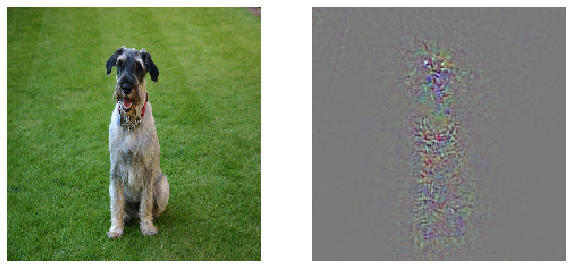

In [11]:
# we normalize the noise between 0 and 1 to plot it
noise_ = noise + np.abs(noise.min())
noise_ /= noise_.max()
print(noise_.min(), noise_.max())

plt.figure(figsize=(10, 10))
# plot
plt.subplot(1, 2, 1)
plt.imshow(image_dog)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noise_[0])
plt.axis('off')
plt.show()

__Question__: Would you expect that noise ? Does this give you information about what makes this dog a Shnauzer ?

Percentage of noise: 0.0
Top-5 predictions:
	 Irish_wolfhound 0.379421
	 standard_schnauzer 0.20018274
	 wire-haired_fox_terrier 0.099777006
	 Scottish_deerhound 0.08937387
	 giant_schnauzer 0.06695007


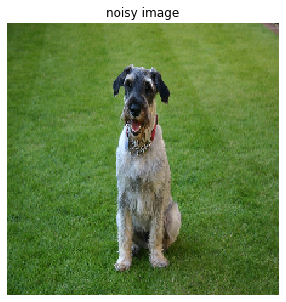


Percentage of noise: 0.1
Top-5 predictions:
	 standard_schnauzer 0.67721677
	 giant_schnauzer 0.121116884
	 wire-haired_fox_terrier 0.07798148
	 Airedale 0.040511392
	 miniature_schnauzer 0.019907828


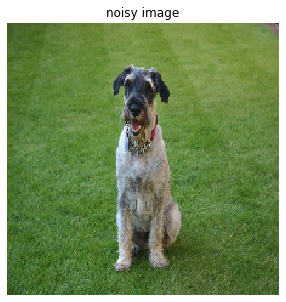


Percentage of noise: 0.2
Top-5 predictions:
	 standard_schnauzer 0.778663
	 giant_schnauzer 0.097853
	 miniature_schnauzer 0.0375693
	 wire-haired_fox_terrier 0.029881757
	 Airedale 0.025686875


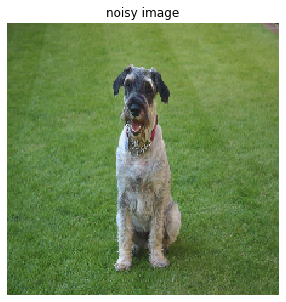


Percentage of noise: 0.3
Top-5 predictions:
	 standard_schnauzer 0.7777699
	 giant_schnauzer 0.08578815
	 miniature_schnauzer 0.07125422
	 Airedale 0.020388057
	 Kerry_blue_terrier 0.02006975


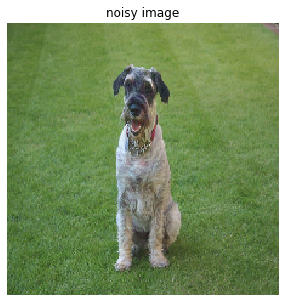


Percentage of noise: 0.4
Top-5 predictions:
	 standard_schnauzer 0.75106925
	 miniature_schnauzer 0.119009934
	 giant_schnauzer 0.07370618
	 Kerry_blue_terrier 0.024001298
	 Airedale 0.014647204


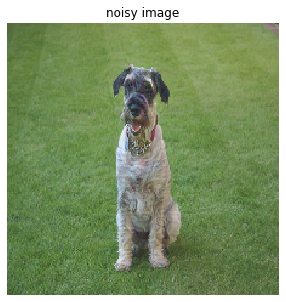

In [12]:
for c in range(5):
    print("Percentage of noise:", c / 10)

    # make prediction with adversarial noise
    x_noisy = x + noise * c / 10
    predictions_noisy = model.predict(x_noisy)
    decoded_predictions_noisy = vgg19.decode_predictions(predictions_noisy)
    print("Top-5 predictions:")
    for i in decoded_predictions_noisy[0]:
        print("\t", i[1], i[2])

    # plot
    noise_to_display = noise_[0] * 255.0
    image_dog_noisy = img_to_array(image_dog) + noise_to_display * c / 10
    image_dog_noisy /= image_dog_noisy.max()
    plt.figure(figsize=(5, 5))
    plt.imshow(image_dog_noisy)
    plt.axis('off')
    plt.title('noisy image')
    plt.show()

    print()

Once we add adversarial noise in this image, the model predict a borzoi. Check it on Google!

Some references about adversarial attack:
*   https://arxiv.org/pdf/1412.6572.pdf 
*   https://distill.pub/2019/advex-bugs-discussion/